In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time

In [61]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Fetching the MNIST dataset and preparing train, validation and test data loaders
train_data = datasets.MNIST(root='./data',train=True,download=True)
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

train_transforms = transforms.Compose([ transforms.RandomRotation(5, fill=(0,)), transforms.RandomCrop(28, padding=2), transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])])

test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[mean], std=[std])])

train_data = datasets.MNIST(root='./data',train=True, download=True,transform=train_transforms)
test_data = datasets.MNIST(root='./data', train=False, download=True,transform=test_transforms)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [62]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,[n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(valid_data)}')
print(f'Number of testing samples: {len(test_data)}')

# The final part of the data processing stage is to create our dataloaders/iterators. We use a batch size of 64 and only shuffle the 
# training data each epoch.

BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data,batch_size=BATCH_SIZE)

Number of training samples: 54000
Number of validation samples: 6000
Number of testing samples: 10000


In [63]:
# Defining the Model:
# The `plot_filter` function takes in a batch of images and a two-dimensional filter and plots the output of that filter applied to all of the images.

def plot_filter(images, filter):

    images = images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    n_images = images.shape[0]
    filtered_images = F.conv2d(images, filter)
    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')
        image = filtered_images[i].squeeze(0)
        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtered')
        ax.axis('off')


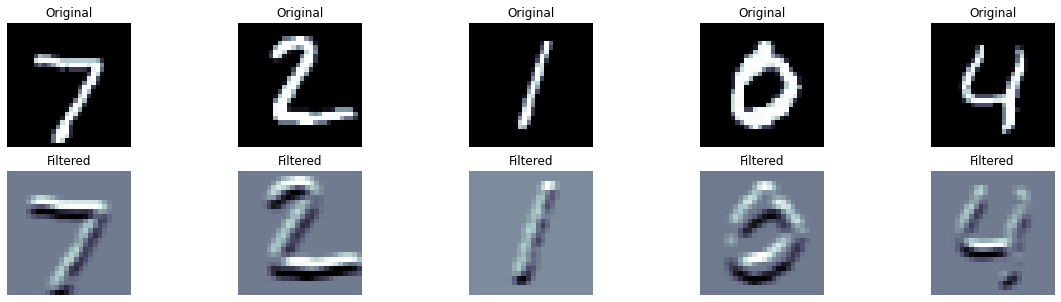

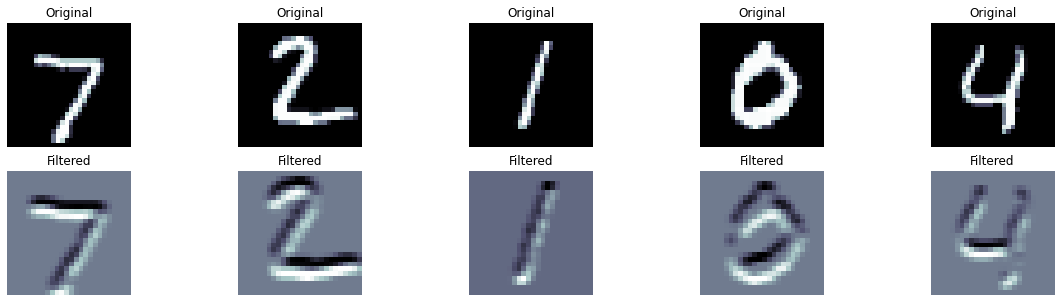

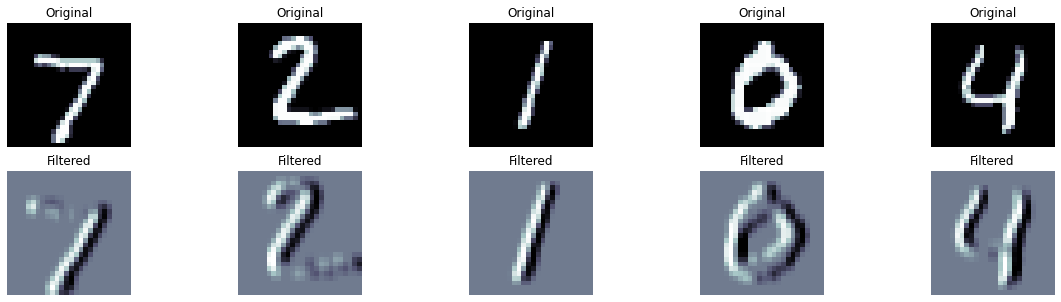

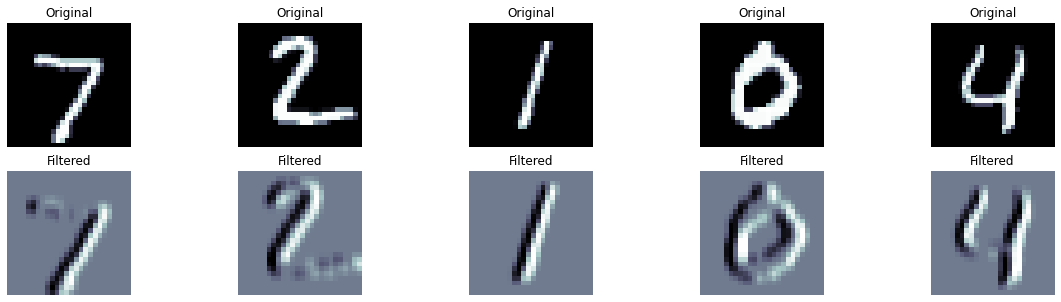

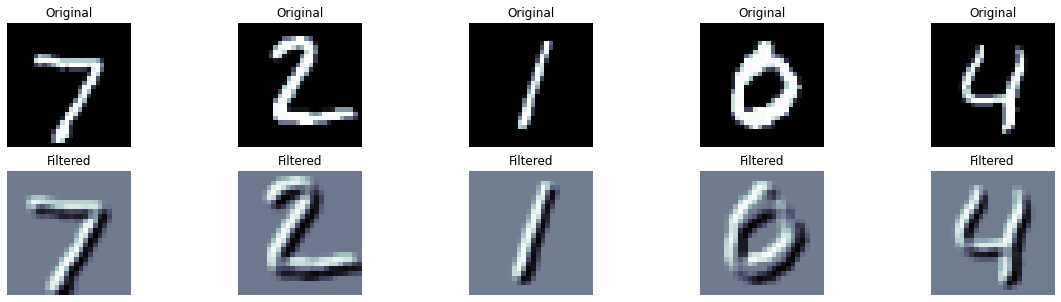

In [64]:
# We'll then get a batch of images to test our handwritten Sobel filters on.
N_IMAGES = 5
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

# The first filter is for detecting horizontal lines.
# We can see on the filtered images that the highest values (the whitest pixels) of the filtered image are where there is a horizontal line
# that is black on top and white below, e.g. the top of the 7 digit. The lowest values (the blackest pixels) of the filtered image are where 
# there is a horizontal line that goes from white to black, e.g. the bottoms of all the digits.

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

# By swapping the first and last rows of the above filter, we get a filter that detects horizontal lines from white on top to black underneath.

horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

# We can also design filters that detect vertical lines. Here's one that detects vertical lines that are black on the left and white on the right.

vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

# To get the opposite filter, one that detects vertical lines that are white on the left and black on the right, we swap the left and right columns.

vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]

plot_filter(images, vertical_filter)

# Finally, we'll design a diagonal detecting filter. This one detects lines pointing towards the top right of the image.

diagonal_filter = [[-2, -1, 0],
                   [-1,  0, 1],
                   [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

In [65]:
# Let's create a function that allows us to see the outputs of a pooling layer on a batch of images.

def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]
    pooled_images = pool(images, kernel_size=pool_size)
    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Subsampled')
        ax.axis('off')

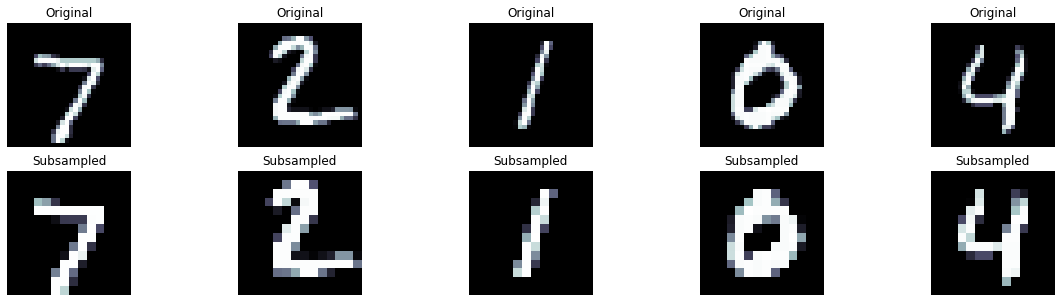

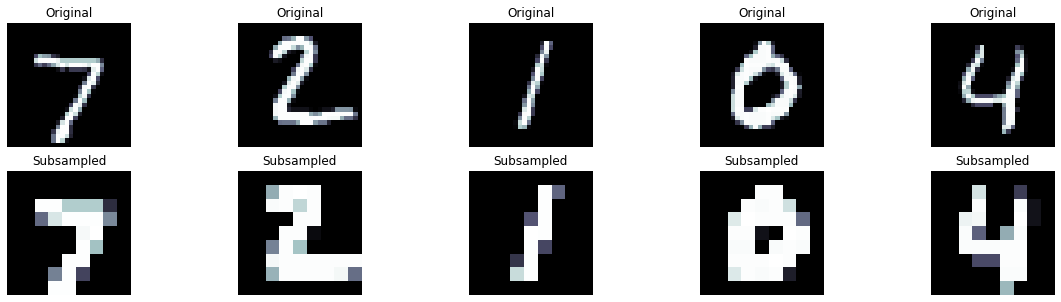

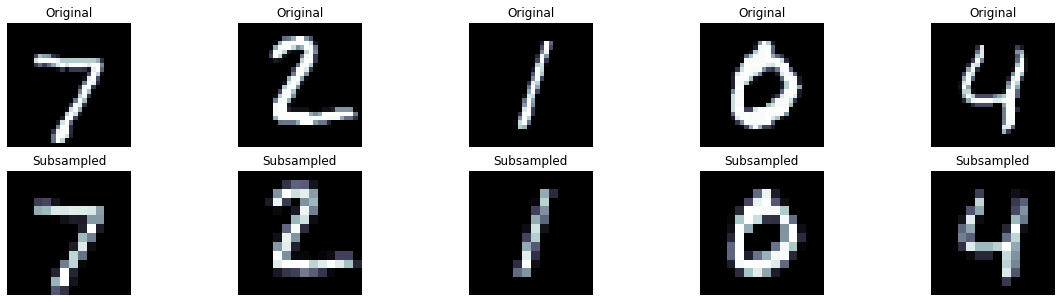

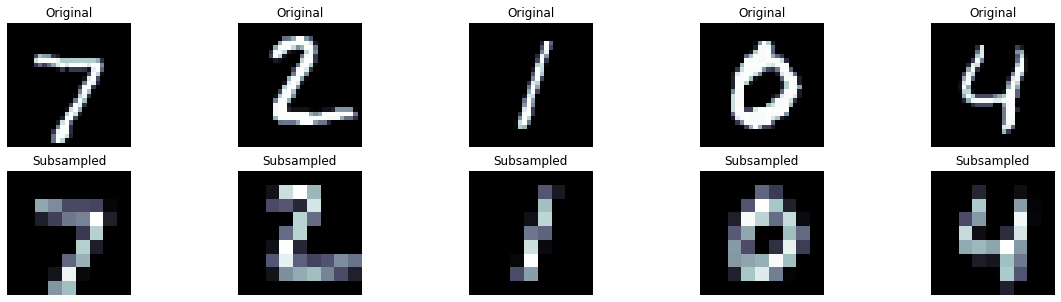

In [66]:
# We can see that for max pooling with a filter size of 2 the image is heavily downsampled - reduced in size/resolution and in quality.

plot_subsample(images, 'max', 2)

plot_subsample(images, 'max', 3)

# For average pooling, the same effect happens, however the loss in quality is not as harsh.

plot_subsample(images, 'avg', 2)

# Again, we can increase the filter size, reducing the resolution of the output image at the cost of image quality - however, the quality drop is not as bad as max pooling.

plot_subsample(images, 'avg', 3)

# Similarly to convolutional layers, if the input image has more than one channel, the filter has a depth equal to the number of channels. Thus, if we did a max pool with 
# a 5x5x6 filter (height and width of 5 and depth of 6), the output at each pixel would be the maximum value of all 150 pixels covered by the filter.

In [67]:

### Defining the Model

class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        #Convolution part (TASK - 1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,padding=2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)

        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)
        # self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        # self.relu1 = torch.nn.ReLU()
        # self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5, stride=1)
        # self.relu2 = torch.nn.ReLU()
        # self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # self.flatten = torch.nn.Flatten()
        # self.fc1 = torch.nn.Linear(16*5*5, 120)
        # self.relu3 = torch.nn.ReLU()
        # self.fc2 = torch.nn.Linear(120, 84)
        # self.relu4 = torch.nn.ReLU()
        # self.fc3 = torch.nn.Linear(84, 10)
        # self.logsoftmax = torch.nn.LogSoftmax(dim=1)

        # DECONV PART (Task - 2)
        self.deconv_pool2 = nn.MaxUnpool2d(kernel_size=2,stride=2,padding=0)
        self.deconv_relu2 = nn.ReLU()
        self.deconv_conv2 = nn.Conv2d(16,6,kernel_size=2,stride=1,padding=1,bias=False)

        self.deconv_pool1=nn.MaxUnpool2d(kernel_size=2,stride=2,padding=0)
        self.deconv_relu1=nn.ReLU()
        self.deconv_conv1=nn.Conv2d(6,1,kernel_size=2,stride=1,padding=1,bias=False)

    def forward(self, x):

        x = self.conv1(x)
        x,i1 = self.pool(x)
        x = F.relu(x)
        x = self.conv2(x)
        x,i2=self.pool(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)

        return x, h

    def forward_deconvnet(self,h):

        unpool2_output = self.deconv_pool2(h, self.i2)
        deconv2_output = self.deconv2(unpool2_output)
        relu2_deconv = torch.relu(deconv2_output)

        unpool1_output = self.deconv_pool1(relu2_deconv, self.i1)
        deconv1_output = self.deconv1(unpool1_output)
        relu1_deconv = torch.relu(deconv1_output)

        deconv3_output = self.deconv3(self.r.view(-1, 120, 1, 1))
        relu3_deconv = torch.relu(deconv3_output)

        return relu1_deconv, relu2_deconv, relu3_deconv

In [68]:
OUTPUT_DIM = 10
model = LeNet(OUTPUT_DIM)
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (deconv_pool2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (deconv_relu2): ReLU()
  (deconv_conv2): Conv2d(16, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (deconv_pool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (deconv_relu1): ReLU()
  (deconv_conv1): Conv2d(6, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
)


In [69]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 62,114 trainable parameters


In [70]:
# Training the Model
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [71]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [72]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        #x = x.to(device)
        x=x
        #y = y.to(device)
        y=y

        optimizer.zero_grad()

        y_pred, _ = model.forward(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [73]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            #x = x.to(device)
            #y = y.to(device)
            x=x
            y=y

            y_pred, _ = model.forward(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [74]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [75]:
# We achieve ~98% validation accuracy achieved by the multilayer perceptron model and achieve 99% validation accuracy.

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer,criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator,criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LeNetModel.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 41s
	Train Loss: 0.391 | Train Acc: 87.64%
	 Val. Loss: 0.182 |  Val. Acc: 94.45%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 0.128 | Train Acc: 95.95%
	 Val. Loss: 0.076 |  Val. Acc: 97.57%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 40s
	Train Loss: 0.096 | Train Acc: 96.99%
	 Val. Loss: 0.070 |  Val. Acc: 98.04%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 39s
	Train Loss: 0.081 | Train Acc: 97.50%
	 Val. Loss: 0.057 |  Val. Acc: 98.25%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 37s
	Train Loss: 0.070 | Train Acc: 97.77%
	 Val. Loss: 0.048 |  Val. Acc: 98.53%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 38s
	Train Loss: 0.063 | Train Acc: 98.03%
	 Val. Loss: 0.042 |  Val. Acc: 98.80%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 38s
	Train Loss: 0.057 | Train Acc: 98.21%
	 Val. Loss: 0.052 |  Val. Acc: 98.35%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 38s
	Train Loss: 0.052 | Train Acc: 98.38%
	 Val. Loss: 0.044 |  Val. Acc: 98.61%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 38s
	Train Loss: 0.045 | Train Acc: 98.57%
	 Val. Loss: 0.043 |  Val. Acc: 98.71%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 38s
	Train Loss: 0.045 | Train Acc: 98.56%
	 Val. Loss: 0.055 |  Val. Acc: 98.47%


In [76]:
# TASK 3 : visualizations
# We load the parameters which performed the best on the validation set and then evaluate our performance on the test set.
# Just like the validation accuracy, we get 99% test accuracy!

model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())
print(model_children)
print(len(model_children))

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)-6):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

# observe the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

for weight in model_weights:
  weight=torch.transpose(weight,0,1)
  print(weight.shape)

[Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Linear(in_features=400, out_features=120, bias=True), Linear(in_features=120, out_features=84, bias=True), Linear(in_features=84, out_features=10, bias=True), MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0)), ReLU(), Conv2d(16, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False), MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0)), ReLU(), Conv2d(6, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)]
12
Total convolutional layers: 2
CONV: Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([6, 1, 5, 5])
CONV: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([16, 6, 5, 5])
torch.Size([1, 6, 5, 5])
torch.Size([6, 16, 5, 5])


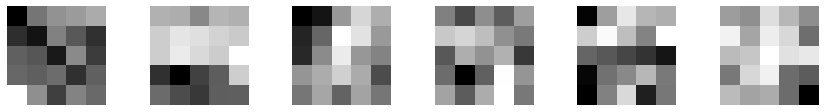

In [77]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')
plt.show()

In [78]:
examples = enumerate(test_iterator)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
img=example_data[1][0].squeeze(0)
print(img.shape)

torch.Size([64, 1, 28, 28])
torch.Size([28, 28])


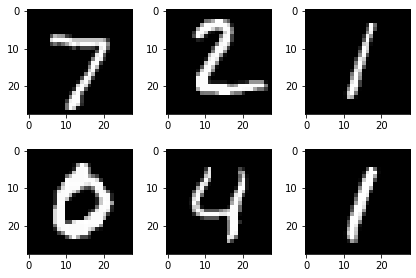

In [79]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')

example_input, example_target = next(iter(test_iterator))

if torch.cuda.is_available():
    model.cuda()

results = [conv_layers[0](example_input)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([6, 28, 28])
Layer 0 feature maps->


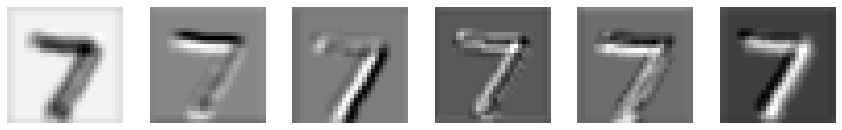

torch.Size([16, 24, 24])
Layer 1 feature maps->


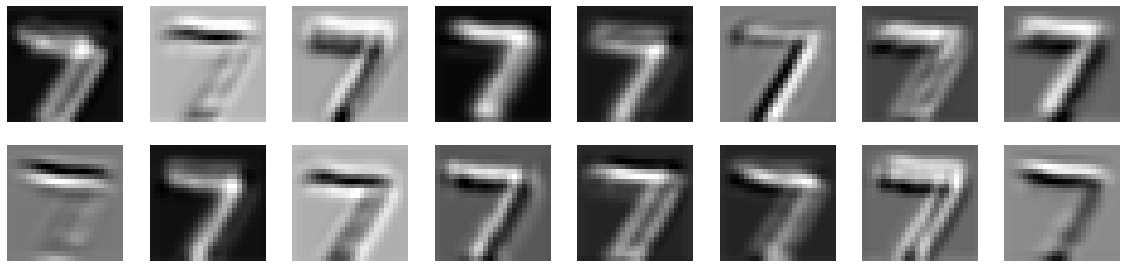

In [80]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(20, 20))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Layer {num_layer} feature maps->")
    plt.show()
    plt.close()

In [81]:
#Extracting convolution outputs for 1st and second convolution layer
layer_viz = outputs[1][0, :, :, :]
layer_viz_2=outputs[0][0,:,:,:]

maxpool_2,indices2=model.pool(torch.relu(layer_viz_2)) #finding the maxpool of the 1st convolution layer output

rectified=torch.relu(layer_viz)
max_pool_data,indices = model.pool(rectified) #maxpool and indices of 2nd maxpool which we will give as input to the deconvnet
#Putting all values of the activations in maxpool to zero except 1.
print("max_pool", max_pool_data.shape)

max_pool torch.Size([16, 12, 12])


In [82]:
max_pool_data[1,:,:]=0
max_pool_data[2,:,:]=0
max_pool_data[3,:,:]=0
max_pool_data[4,:,:]=0
max_pool_data[5,:,:]=0
max_pool_data[6,:,:]=0
max_pool_data[7,:,:]=0
max_pool_data[8,:,:]=0
max_pool_data[9,:,:]=0
max_pool_data[10,:,:]=0
max_pool_data[11,:,:]=0
max_pool_data[12,:,:]=0
max_pool_data[13,:,:]=0
max_pool_data[14,:,:]=0
max_pool_data[15,:,:]=0
print(max_pool_data)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 3.1043, 2.7503,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [83]:
deconv1_pool2=model.deconv_pool2(max_pool_data,indices)
print("shape",deconv1_pool2.shape)
    #deconv1_conv2=model.deconv_conv2(deconv1_pool2)
    #print("shape", deconv1_conv2.shape)
deconv1_act2=model.deconv_relu2(deconv1_pool2)
print(deconv1_act2)
print("act shape", deconv1_act2.shape)
model.deconv_conv2.weight=nn.Parameter(torch.transpose(model_weights[1],0,1))
deconv1_conv2=model.deconv_conv2(deconv1_act2)
print("conv shape", deconv1_conv2.shape)

shape torch.Size([16, 24, 24])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 

Layer 1 feature maps->


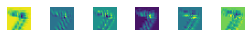

In [84]:
#Visualization of layer before 2nd maxpooling
for i,layer_v in enumerate(deconv1_conv2):
      plt.subplot(8, 8, i + 1)
      plt.imshow(layer_v.detach().numpy())
      plt.axis("off")
print(f"Layer {num_layer} feature maps->")
plt.show()
plt.close()

In [85]:
deconv_pool1=model.deconv_pool1(maxpool_2,indices2)
deconv_relu2=model.deconv_relu2(deconv_pool1)
model.deconv_conv1.weight=nn.Parameter(torch.transpose(model_weights[0],0,1))
deconv_conv1=model.deconv_conv1(deconv_relu2)
print(deconv_conv1.shape)

torch.Size([1, 26, 26])


Layer 1 feature maps->


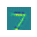

In [86]:
for i,layer_v2 in enumerate(deconv_conv1):
      plt.subplot(8, 8, i + 1)
      plt.imshow(layer_v2.detach().numpy())
      plt.axis("off")
print(f"Layer {num_layer} feature maps->")
plt.show()
plt.close()

In [87]:
#print(max_pool_data.shape)
layer_viz = layer_viz.data

#print(layer_viz.size())
#print(layer_viz)
layer_viz[0,:,:]=0
layer_viz[1,:,:]=0
layer_viz[2,:,:]=0
layer_viz[3,:,:]=0
layer_viz[4,:,:]=0
layer_viz[5,:,:]=0
layer_viz[6,:,:]=0
layer_viz[7,:,:]=0
layer_viz[8,:,:]=0
layer_viz[9,:,:]=0
layer_viz[10,:,:]=0
layer_viz[11,:,:]=0
layer_viz[12,:,:]=0
layer_viz[13,:,:]=0
layer_viz[14,:,:]=0

max_pool_data,indices=model.pool(layer_viz)

print(model_weights[1].shape)

torch.Size([16, 6, 5, 5])


In [88]:
#model.load_state_dict(torch.load('LeNetModel.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.042 | Test Accuracy: 98.67%


In [89]:
# Examining the Model

def get_predictions(model, iterator):

    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            #x = x.to(device)
            x=x
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)

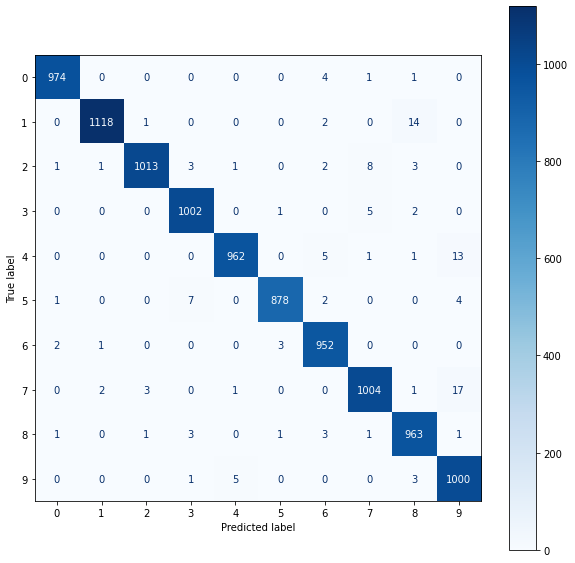

In [90]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

plot_confusion_matrix(labels, pred_labels)

corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

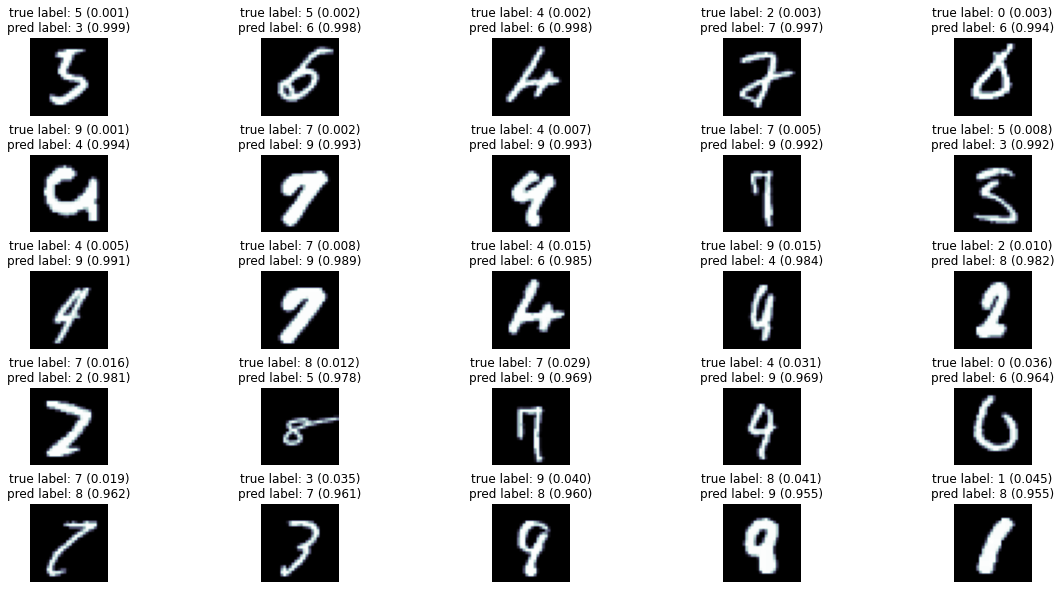

In [91]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)


N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)
